# 2.1 LangChain vs LangGraph (feat. LangGraph 개념 설명)

- LangChain을 활용한 간단한 `llm.invoke()` 예제를 살펴보고, 이를 LangGraph로 구현해보는 과정을 진행합니다.
- LangGraph의 개념과 주요 기능을 이해하고, 두 프레임워크의 차이점을 비교합니다.

## 환경설정

- `LangChain` 활용을 위해 필요한 패키지들을 설치합니다
- 최신 버전을 설치해도 정상적으로 동작해야 하지만, 버전 명시가 필요하다면 `requirements.txt`를 참고해주세요

In [1]:
%pip install -q python-dotenv langchain-openai


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


- 먼저 `.env` 파일의 환경변수를 불러옵니다
- `OPENAI_API_KEY`, `GEMINI_API_KEY`, `ANTHROPIC_API_KEY` 등과 같이 환경변수를 설정하면 편하게 사용할 수 있습니다

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI

query = '인프런에는 어떤 강의가 있나요?'

llm = ChatOpenAI(model='gpt-4o-mini') # 테스트의 경우에는 작은 모델을 사용합니다
llm.invoke(query)

AIMessage(content='인프런은 다양한 주제를 다루는 온라인 강의 플랫폼으로, 주로 IT, 프로그래밍, 데이터 사이언스, 웹 개발, 모바일 개발, 디자인, 마케팅 등 여러 분야의 강의를 제공합니다. 예를 들어, 다음과 같은 강의가 있을 수 있습니다:\n\n1. **프로그래밍 언어**: Python, Java, JavaScript, C++, Ruby 등\n2. **웹 개발**: HTML, CSS, React, Angular, Vue.js 등의 프론트엔드 기술과 Node.js, Django, Flask 등의 백엔드 기술\n3. **데이터 사이언스**: 머신러닝, 데이터 분석, 데이터 시각화, R 및 Python을 이용한 데이터 처리\n4. **모바일 개발**: iOS 및 Android 앱 개발\n5. **디자인**: UX/UI 디자인, 포토샵, 일러스트레이터 등\n6. **DevOps & 클라우드**: AWS, Docker, Kubernetes 등의 클라우드 및 DevOps 관련 강의\n7. **마케팅**: 디지털 마케팅, SEO, 콘텐츠 마케팅 등\n\n각 강의는 초급자부터 고급자까지 다양한 수준으로 제공되며, 강의 내용과 강사의 스타일에 따라 선택할 수 있습니다. 인프런 웹사이트를 방문하면 최신 강의 목록과 상세 정보를 확인할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 289, 'prompt_tokens': 18, 'total_tokens': 307, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}

- `LangGraph` 활용을 위해 필요한 패키지를 설치합니다
- 최신 버전을 설치해도 정상적으로 동작해야 하지만, 버전 명시가 필요하다면 `requirements.txt`를 참고해주세요

In [4]:
%pip install -q langgraph


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


- `state`는 LangGraph 에이전트의 상태를 나타내는 데이터 구조입니다.
- `state`는 `TypedDict`를 사용하여 정의되며, 이는 Python의 타입 힌팅을 통해 구조를 명확히 합니다.
    - 지금 예제에서는 간단하게 `messages`라는 필드만 있습니다.
    - 필요에 따라 다양한 값들을 활용할 수 있습니다.
        - 2.2 회차에서 다룰 예정입니다.
- `state`는 에이전트의 동작을 결정하는 데 사용되며, 각 노드에서 상태를 업데이트하거나 참조할 수 있습니다.
- `state`는 LangGraph의 노드 간에 전달되며, 에이전트의 상태 전이를 관리합니다.

In [5]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

class AgentState(TypedDict):
    messages: list[Annotated[AnyMessage, add_messages]]

- 위에 선언한 `AgentState`를 활용하여 `StateGraph`를 생성합니다.

In [6]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

- `graph`에 추가할 `node`를 생성합니다
- `node`는 기본적으로 함수(function)로 정의되고, 뒤에서 다루지만 다른 에이전트(agent)를 활용할 수도 있습니다

In [7]:
def generate(state: AgentState) -> AgentState:
    """
    `generate` 노드는 사용자의 질문을 받아서 응답을 생성하는 노드입니다.
    """
    messages = state['messages']
    ai_message = llm.invoke(messages)
    return {'messages': [ai_message]}

- `node`를 생성한 후에 `edge`로 연결합니다

In [8]:
graph_builder.add_node('generate', generate)

- 모든 그래프는 `START(시작)`와 `END(종료)`가 있습니다
    - `END`를 explicit하게 선언하지 않는 경우도 종종 있지만, 가독성을 위해 작성해주는 것을 권장합니다

In [9]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'generate')
graph_builder.add_edge('generate', END)

- `node`를 생성하고 `edge`로 연결한 후에 `compile` 메서드를 호출하여 `Graph`를 생성합니다

In [11]:
graph = graph_builder.compile()

- `compile` 후에는 그래프를 시각화하여 확인할 수 있습니다
- 의도한대로 그래프가 생성됐는지 확인하는 습관을 기르는 것이 좋습니다
    - `git`에서 코드 작업물을 commit하기 전에 `git diff`를 통해 변경사항을 확인하는 것과 같습니다

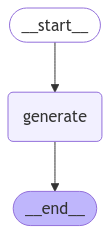

In [12]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
from langchain_core.messages import HumanMessage

initial_state = {'messages': [HumanMessage(query)]}
graph.invoke(initial_state)

{'messages': [AIMessage(content='인프런(Infrun)은 다양한 분야의 온라인 강의를 제공하는 플랫폼으로, 주로 IT와 프로그래밍 관련 강의가 많습니다. 여기에는 다음과 같은 주제가 포함됩니다:\n\n1. **프로그래밍 언어**: Python, Java, JavaScript, C++, Ruby 등.\n2. **웹 개발**: HTML, CSS, React, Vue.js, Node.js 등.\n3. **모바일 개발**: iOS, Android, Flutter 등.\n4. **데이터 과학**: 데이터 분석, 머신러닝, 딥러닝, R, Pandas 등.\n5. **클라우드**: AWS, Azure, Google Cloud 등.\n6. **DevOps**: Docker, Kubernetes, CI/CD 등.\n7. **게임 개발**: Unity, Unreal Engine 등.\n8. **디자인**: UI/UX 디자인, 그래픽 디자인 등.\n9. **기타**: 프로젝트 관리, IT 자격증 준비 등.\n\n각 강의는 강사에 따라 진행 방식이나 내용이 다르므로, 원하는 주제에 맞는 강의를 찾아보시면 좋습니다. 인프런 웹사이트를 방문하면 최신 강의 목록과 강좌에 대한 자세한 정보를 확인할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 263, 'prompt_tokens': 18, 'total_tokens': 281, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-